In [93]:
from dotenv import load_dotenv
load_dotenv(".env")

False

#### State

When building an agent, it's important to consider the information that you want to track over time. We'll use LangGraph's pre-built [`MessagesState` object](https://langchain-ai.github.io/langgraph/concepts/low_level/#messagesstate), which is a just dictionary with a `messages` key that appends messages returned by nodes [as its update logic](https://langchain-ai.github.io/langgraph/concepts/low_level/#reducers). However, LangGraph gives you flexibility to track other information. We'll define a custom `State` object that extends `MessagesState` and adds a `url_input`


In [83]:
from langgraph.graph import MessagesState

class State(MessagesState):
    # We can add a specific key to our state for the email input
    url: str


In [84]:
from asyncio import streams
from datetime import datetime
from pydantic import BaseModel
from langgraph.types import Command
from typing import Literal
from langchain_core.tools import tool
import requests
import csv
from bs4 import BeautifulSoup

@tool
def url_handler(url: str) -> str:
    """
    Pulls the HTML content from the URL
    Args: 
        url: url string.
    Returns:
        the content of the HTML in string.
    """

    r = requests.get(url)
    r = r.text
    soup = BeautifulSoup(r, 'html.parser')
    body_info = str(soup.find_all('tbody'))

    return body_info


@tool
def write_to_csv(data: list, filename: str = "output.csv") -> bool:
    """
    Writes a list of dictionaries to a CSV file.
    Args:
        data: List of dictionaries, where each dict represents a row.
        filename: Name of the CSV file to write to.
    Returns:
        True if successful, False otherwise.
    """
    if not data:
        return False
    try:
        # Get the fieldnames from the first dict
        fieldnames = data[0].keys()
        with open(filename, "w", newline="", encoding="utf-8") as csvfile:
            writer = csv.DictWriter(csvfile, fieldnames=fieldnames)
            writer.writeheader()
            writer.writerows(data)
        return True
    except Exception as e:
        print(f"Error writing CSV: {e}")
        return False


@tool
class Done(BaseModel):
      """E-mail has been sent."""
      done: bool

In [85]:

%load_ext autoreload
%autoreload 2

from prompts.agent_prompt import agent_system_prompt
from prompts.tools_prompts import URL_TOOLS_PROMPT, CSV_TOOLS_PROMPT
from langchain.chat_models import init_chat_model
from langgraph.graph import END

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [86]:
# Collect all tools
tools = [url_handler, write_to_csv, Done]
tools_by_name = {tool.name: tool for tool in tools}
background = None

llm = init_chat_model("openai:gpt-4.1", temperature=0.0)
llm_with_tools = llm.bind_tools(tools, tool_choice="any")

def llm_call(state: State):
    """LLM decides whether to call a tool or not"""

    return {
        "messages": [
            # Invoke the LLM
            llm_with_tools.invoke(
                # Add the system prompt
                [   
                    {"role": "system", "content": agent_system_prompt.format(
                        url_tools_prompt=URL_TOOLS_PROMPT,
                        csv_tools_prompt=CSV_TOOLS_PROMPT,
                        background=background,
                    ) + f"\n\nThe URL to scrape is: {state['url']}"
                }
                ]
                # Add the current messages to the prompt
                + state["messages"]
            )
        ]
    }

def tool_handler(state: State):
    """Performs the tool call."""

    # List for tool messages
    result = []
    
    # Iterate through tool calls
    for tool_call in state["messages"][-1].tool_calls:
        # Get the tool
        tool = tools_by_name[tool_call["name"]]
        # Run it
        observation = tool.invoke(tool_call["args"])
        # Create a tool message
        result.append({"role": "tool", "content" : observation, "tool_call_id": tool_call["id"]})
    
    # Add it to our messages
    return {"messages": result}

def should_continue(state: State) -> Literal["tool_handler", "__end__"]:
    """Route to tool handler, or end if Done tool called."""
    
    # Get the last message
    messages = state["messages"]
    last_message = messages[-1]
    
    # Check if it's a Done tool call
    if last_message.tool_calls:
        for tool_call in last_message.tool_calls: 
            if tool_call["name"] == "Done":
                return "__end__"
            else:
                return "tool_handler"
                
    return "__end__"

In [87]:
from langgraph.graph import StateGraph, START, END

# Build workflow
overall_workflow = StateGraph(State, input=StateInput)

# Add nodes
overall_workflow.add_node("llm_call", llm_call)
overall_workflow.add_node("tool_handler", tool_handler)

# Add edges
overall_workflow.add_edge(START, "llm_call")
overall_workflow.add_conditional_edges(
    "llm_call",
    should_continue,
    {
        "tool_handler": "tool_handler",
        "__end__": END,
    },
)
overall_workflow.add_edge("tool_handler", "llm_call")

# Compile the agent
agent = overall_workflow.compile()

In [88]:
def show_graph(graph, xray=False):
    """Display a LangGraph mermaid diagram with fallback rendering.
    
    Handles timeout errors from mermaid.ink by falling back to pyppeteer.
    
    Args:
        graph: The LangGraph object that has a get_graph() method
    """
    from IPython.display import Image
    try:
        # Try the default renderer first
        return Image(graph.get_graph(xray=xray).draw_mermaid_png())
    except Exception as e:
        # Fall back to pyppeteer if the default renderer fails
        import nest_asyncio
        nest_asyncio.apply()
        from langchain_core.runnables.graph import MermaidDrawMethod
        return Image(graph.get_graph().draw_mermaid_png(draw_method=MermaidDrawMethod.PYPPETEER))

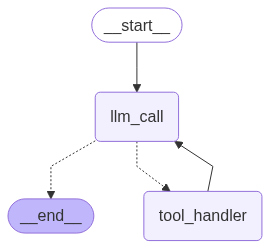

In [89]:
show_graph(agent)


In [90]:
# show_graph(overall_workflow, xray=True)

In [92]:
from langchain_core.messages import HumanMessage

response = agent.invoke({"url": "https://athletics.hamilton.edu/sports/mens-swimming-and-diving/roster", 
                        "messages": [HumanMessage(content="Find me all information about the coaches in the roster.")]})